#**HW4 : Recurrent Neural Networks**
In this homework, we will explore how to develop a simple Recurrent Neural Network (RNN) for sentiment analysis. As a dataset, we will use the IMDB dataset. It contains the text of some reviews and the sentiment given by the authors of the reviews (positive review or negative review). The input to the RNN is the sequence of words that compose a review. The learning task consists in predicting the sentiment of the review.
In the first part, we will learn how to develop a simple RNN, then we will explore the differences in terms of computational load, number of parameters, and performances with respect to more advanced recurrent models, like LSTM and GRU. Subsequently, we experiment with the bi-directional model to unveil the strengths and the weaknesses of this technique. Finally, we will explore how to face overfitting by Dropout. 

##[TO COMPLETE] Exercise 4.1: Simple RNN

Let's start by importing Tensorflow, Keras and Numpy

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

np.random.seed(42)

###Load dataset:
In this HW, we use the same datset used in the HW2, the IMDB dataset. The dataset contains 50,000 movie reviews from IMDB, labeled by sentiment (positive/negative). Reviews have been preprocessed, and each review is encoded as a sequence of word indexes. For convenience, the words are indexed by the overall frequency in the dataset, so that for example the integer "3" encodes the 3rd most frequent word in the data. For testing purposes, we will only consider the first 10,000  most common words.
By default, the load_data method returns a breakdown of the dataset into training and test sets. Both these sets contain 25,000 samples. To also have a validation set, we split the test set in half.

In [2]:

num_words = 10000
(X_train, y_train), (X_test, y_test) = keras.datasets.imdb.load_data(num_words=num_words)
(X_valid, X_test) = X_test[:12500], X_test[12500:]
(y_valid, y_test) = y_test[:12500], y_test[12500:]

17465344/17464789 [==============================] - 0s 0us/step


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

Let's also get the word indexs (word to word-id)

In [3]:
word_index = keras.datasets.imdb.get_word_index()

1646592/1641221 [==============================] - 0s 0us/step


Now we create a reverse index (word-id to word) method. Moreover, we add three special word-ids to encode:
- the padding;
- the start of a sequence;
- a word that is not in the vocabulary of the first 10,000 most common words.

Moreover, we also add an "unknown" placeholder for all the other symbols (not words) that may occur.
*Please, notice that Keras does not use index 0, so we can shift the indices only by 3 positions.*

In [4]:
reverse_index = {word_id + 3: word for word, word_id in word_index.items()}
reverse_index[0] = "<pad>" # padding
reverse_index[1] = "<sos>" # start of sequence
reverse_index[2] = "<oov>" # out-of-vocabulary
reverse_index[3] = "<unk>" # unknown

def decode_review(word_ids):
    return " ".join([reverse_index.get(word_id, "<err>") for word_id in word_ids])

Let's print a training sample and its target value

In [5]:
decode_review(X_train[0])

"<sos> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <oov> is an amazing actor and now the same being director <oov> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <oov> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <oov> to the two little boy's that played the <oov> of norman and paul they were just brilliant children are often left out of the <oov> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what

In [6]:
y_train[0]

1

Because of a limit of Keras, to feed the input data into an RNN model we have to create sequences that have the same length. We use keras.preprocessing.sequence.pad_sequences() to preprocess X_train: this will create a 2D array of 25,000 rows (one per review) and maxlen=500 columns. Because of that, reviews longer than 500 words will be cut, while reviews shorter than 500 words will be padded with zeros.

In [7]:
maxlen = 500
X_train_trim = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen)
X_test_trim = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen)
X_valid_trim = keras.preprocessing.sequence.pad_sequences(X_valid, maxlen=maxlen)

###[TO COMPLETE] Define the model:
Let's define the model: 
- The first layer is an Embedding layer, with input_dim=num_words and output_dim=10. The model will gradually learn to represent each of the 10,000 words as a 10-dimensional vector. So the next layer will receive 3D batches of shape (batch size, 500, 10)
- The second layer is the recurrent one. In particular, in this case, we use a [SimpleRNN](https://www.tensorflow.org/api_docs/python/tf/keras/layers/SimpleRNN) 
- The output layer is a Dense layer with a sigmoid activation function since this is a binary classification problem

[TO COMPLETE] In the following cell, we already inserted in the model the first Embedding layer. Add the recurrent layer (using 32 units), and the output layer. Select the right activation function for the output layer and motivate your choice. Finally, select the right loss function inserting the right value for the "loss" parameter in model.compile() and motivate your choice.
Please, insert your answers in a new text cell below this one, immediately before the code.

For the activation function I chose the sigmoid since it returns as output a value between 0 and 1; therefore, this value can be interpreted as a probability that encodes how confident the model is of the example being in the class, and thus it is suitable for binary classification problems such as this one. Moreover, i chose as loss function the binary cross-entropy, that is also the most used loss function when dealing with binary classification tasks.

In [8]:
model = keras.models.Sequential()
model.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model.add(keras.layers.SimpleRNN(units=32))
model.add(keras.layers.Dense(units=1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer="adam", metrics=["accuracy"])

Let's print a summary of the model. Specifically, note the number of parameters of the RNN layer.

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 10)          100000    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 32)                1376      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 101,409
Trainable params: 101,409
Non-trainable params: 0
_________________________________________________________________


###Train the model:
Now we have to train the model

In [11]:
history = model.fit(X_train_trim, y_train,
                    epochs=10, batch_size=128, validation_data=(X_valid_trim, y_valid))

Epoch 1/10
196/196 [==============================] - 81s 393ms/step - loss: 0.6905 - accuracy: 0.5266 - val_loss: 0.6639 - val_accuracy: 0.5994
Epoch 2/10
196/196 [==============================] - 76s 389ms/step - loss: 0.5934 - accuracy: 0.7012 - val_loss: 0.6033 - val_accuracy: 0.6551
Epoch 3/10
196/196 [==============================] - 77s 390ms/step - loss: 0.4343 - accuracy: 0.8081 - val_loss: 0.4127 - val_accuracy: 0.8342
Epoch 4/10
196/196 [==============================] - 77s 394ms/step - loss: 0.2556 - accuracy: 0.8971 - val_loss: 0.3979 - val_accuracy: 0.8407
Epoch 5/10
196/196 [==============================] - 77s 394ms/step - loss: 0.1686 - accuracy: 0.9392 - val_loss: 0.4041 - val_accuracy: 0.8421
Epoch 6/10
196/196 [==============================] - 77s 391ms/step - loss: 0.1125 - accuracy: 0.9644 - val_loss: 0.4571 - val_accuracy: 0.8334
Epoch 7/10
196/196 [==============================] - 76s 390ms/step - loss: 0.0804 - accuracy: 0.9755 - val_loss: 0.4979 - val_ac

Print the values of accuracy and the loss , and evaluate the model on the test set

391/391 - 12s - loss: 0.6119 - accuracy: 0.8428
accuracy: 84.28%


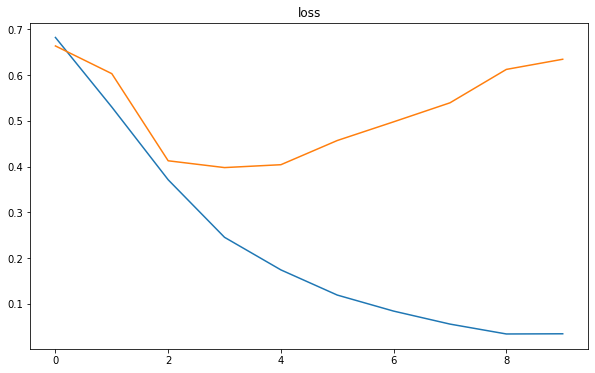

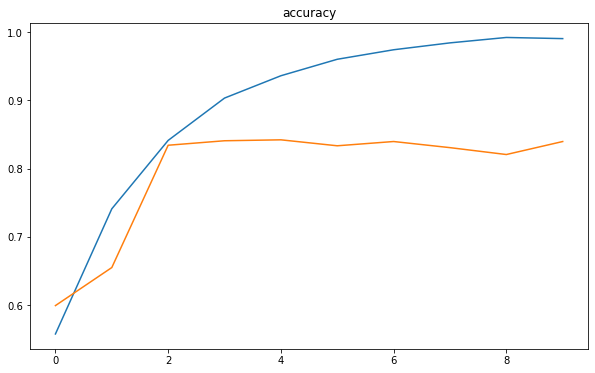

In [12]:
def plot_loss(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['loss'])
  plt.plot(history.epoch,history.history['val_loss'])
  plt.title('loss')

def plot_accuracy(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['accuracy'])
  plt.plot(history.epoch,history.history['val_accuracy'])
  plt.title('accuracy')

plot_loss(history)

plot_accuracy(history)

scores = model.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

##[TO COMPLETE] Exercise 4.2: LSTM and GRU
**[TO COMPLETE]**: In this Exercise, you have to implement 2 models, similar to the previous one that, instead of exploiting the RNN layer, use an LSTM and a GRU Layer, respectively. For each model print the summary. Then, train it and plot the values of accuracy and loss. Finally, discuss the differences in terms of performance, the number of parameters, and training time. Note that you can use a different number of units than the one used in the RNN example.

**[TO COMPLETE]**: In order to perform a fair comparison (definition of fair: models have to use more or less the same number of parameters) between the given RNN model and the other 2 models (LSTM and GRU), how many units do they have to use, respectively?

*insert cells (code and text) with results and discussion immediately after this cell*

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 10)          100000    
_________________________________________________________________
lstm (LSTM)                  (None, 14)                1400      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 15        
Total params: 101,415
Trainable params: 101,415
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
196/196 [==============================] - 36s 30ms/step - loss: 0.6546 - accuracy: 0.5870 - val_loss: 0.5043 - val_accuracy: 0.7454
Epoch 2/10
196/196 [==============================] - 5s 27ms/step - loss: 0.3823 - accuracy: 0.8479 - val_loss: 0.3398 - val_accuracy: 0.8611
Epoch 3/10
196/196 [==============================] - 5s 27ms/step - loss: 0.2610 - accurac

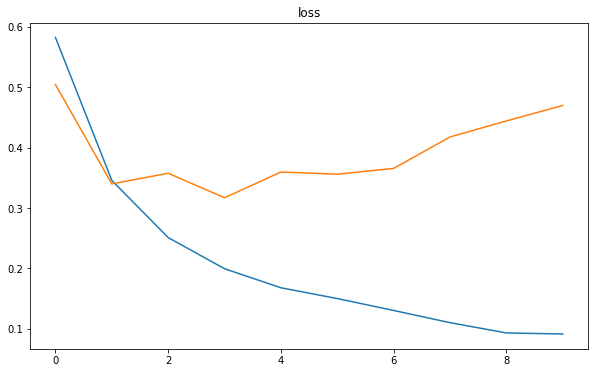

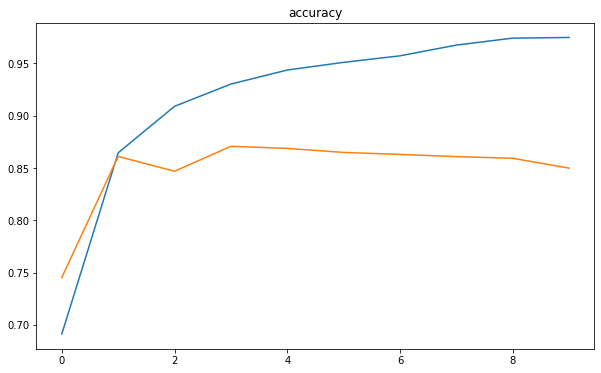

In [13]:
# LSTM

model_LSTM = keras.models.Sequential()
model_LSTM.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model_LSTM.add(keras.layers.LSTM(units=14))
model_LSTM.add(keras.layers.Dense(units=1, activation='sigmoid'))

model_LSTM.compile(loss='binary_crossentropy', optimizer="adam", metrics=["accuracy"])

model_LSTM.summary()

history_LSTM = model_LSTM.fit(X_train_trim, y_train,
                    epochs=10, batch_size=128, validation_data=(X_valid_trim, y_valid))

plot_loss(history_LSTM)

plot_accuracy(history_LSTM)

scores_LSTM = model_LSTM.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model_LSTM.metrics_names[1], scores_LSTM[1]*100))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 10)          100000    
_________________________________________________________________
gru (GRU)                    (None, 16)                1344      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 101,361
Trainable params: 101,361
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
196/196 [==============================] - 7s 29ms/step - loss: 0.6492 - accuracy: 0.5884 - val_loss: 0.4093 - val_accuracy: 0.8163
Epoch 2/10
196/196 [==============================] - 5s 26ms/step - loss: 0.3097 - accuracy: 0.8755 - val_loss: 0.3298 - val_accuracy: 0.8649
Epoch 3/10
196/196 [==============================] - 5s 27ms/step - loss: 0.2261 - accuracy

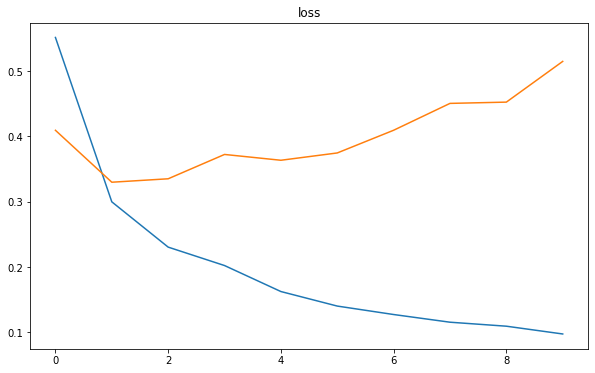

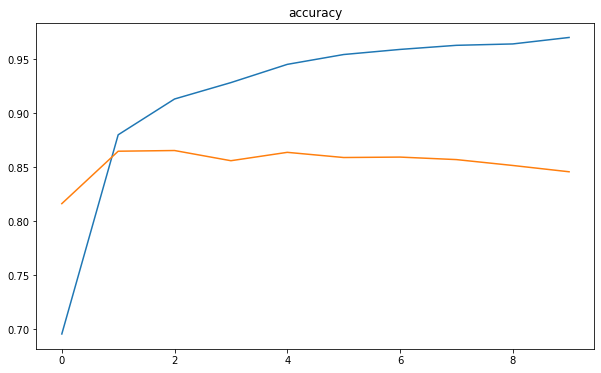

In [14]:
#GRU

model_GRU = keras.models.Sequential()
model_GRU.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model_GRU.add(keras.layers.GRU(units=16))
model_GRU.add(keras.layers.Dense(units=1, activation='sigmoid'))

model_GRU.compile(loss='binary_crossentropy', optimizer="adam", metrics=["accuracy"])

model_GRU.summary()

history_GRU = model_GRU.fit(X_train_trim, y_train,
                    epochs=10, batch_size=128, validation_data=(X_valid_trim, y_valid))

plot_loss(history_GRU)

plot_accuracy(history_GRU)

scores_GRU = model_GRU.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model_GRU.metrics_names[1], scores_GRU[1]*100))

The two models achieved the following perfomances:

* LSMT - loss: 0.4496 - accuracy: 0.8569
* GRU  - loss: 0.5063 - accuracy: 0.8482

By looking at the plots above, it is possible to notice how both these two models overfit the training set (even if they do it less with respect to the SimpleRNN model) . Regarding the training time, both models averaged a 5s time for each training epoch. Notice that I used GPUs in order to diminish the overall training time.

<br> Moreover, as the hints above suggested, I changed the number of units of the LSTM and GRU layers in order to make a fair comparison with the previous SimpleRNN model, which had 101,409 trainable parameters. <br> By setting the number of units for the LSMT layer at 14, the network had 101,415 trainable parameters, while instead for the GRU layer I choose to use 16 units, thus obtaining a network with 101,361 trainable parameters.

##Bidirectional LSTM
Let's modify the previous code by using a bidirectional LSTM instead of a simple LSTM. In Keras, it is possible to define a bidirectional layer by using [tf.keras.layers.Bidirectional](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional). Note that this wrapper requires as argument a layer, in our case we use [tf.keras.layers.LSTM](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM)


In [15]:
model_bidirectional = keras.models.Sequential()
model_bidirectional.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model_bidirectional.add(keras.layers.Bidirectional(keras.layers.LSTM(32)))
model_bidirectional.add(keras.layers.Dense(1, activation="sigmoid"))

model_bidirectional.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

model_bidirectional.summary()

history = model_bidirectional.fit(X_train_trim, y_train,
                    epochs=5, batch_size=128, validation_data=(X_valid_trim, y_valid))

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 10)          100000    
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                11008     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 111,073
Trainable params: 111,073
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
196/196 [==============================] - 12s 50ms/step - loss: 0.6566 - accuracy: 0.5894 - val_loss: 0.4017 - val_accuracy: 0.8250
Epoch 2/5
196/196 [==============================] - 9s 46ms/step - loss: 0.3400 - accuracy: 0.8647 - val_loss: 0.3672 - val_accuracy: 0.8459
Epoch 3/5
196/196 [==============================] - 9s 46ms/step - loss: 0.2777 - accuracy: 

391/391 - 6s - loss: 0.3423 - accuracy: 0.8734
accuracy: 87.34%


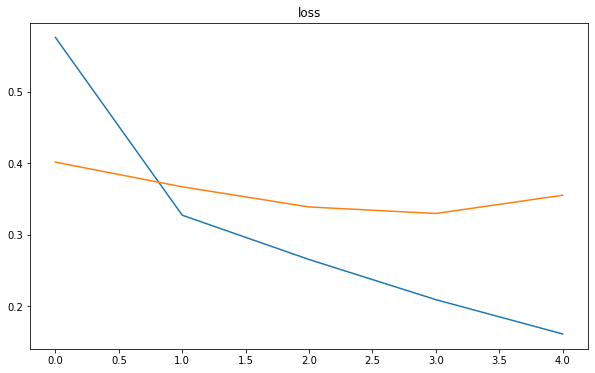

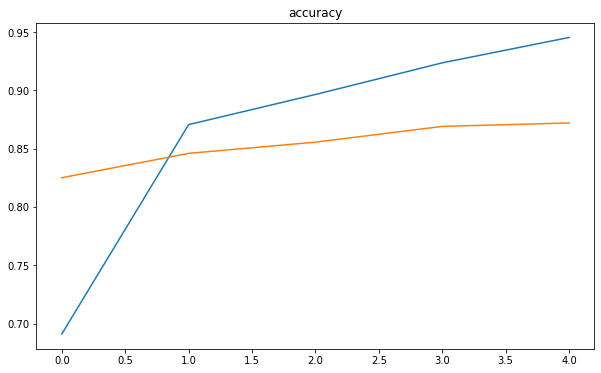

In [16]:
plot_loss(history)

plot_accuracy(history)

scores = model_bidirectional.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model_bidirectional.metrics_names[1], scores[1]*100))

##[TO COMPLETE] Exercise 4.3: Dropout
In the bi-directional model is it possible to notice that the model overfits the training data.
A possible solution to this problem could be applying the dropout technique to input or output layers.

In Keras, to apply dropout you have to add a [keras.layers.Dropout](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout) layer.

**[TO COMPLETE]**: modify the code of the previous exercise adding the Dropout to the input and/or output layers. Find the Dropout probability that reduces the overfitting issue.

**[TO COMPLETE]** Is it possible to modify the values of some other hyper-parameters to mitigate overfitting? And if this is the case, explain why and perform an experimental study demonstrating your point.

*insert cells (code and text) with results and discussion immediately after this cell*

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 10)          100000    
_________________________________________________________________
dropout (Dropout)            (None, None, 10)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                11008     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 111,073
Trainable params: 111,073
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
196/196 [==============================] - 13s 50ms/step - loss: 0.6469 - accuracy: 0.5828 - val_loss: 0

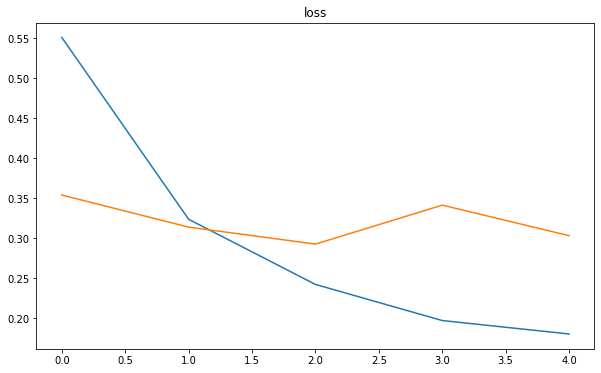

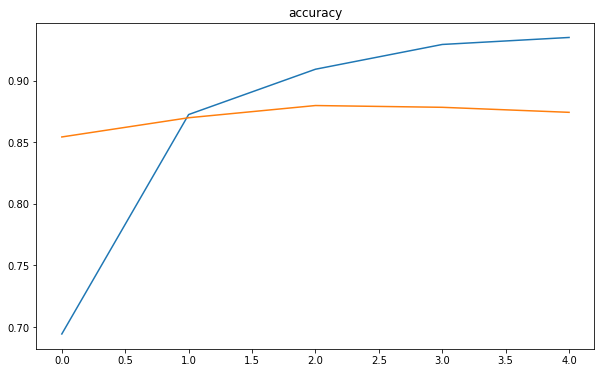

In [17]:
model_bidirectional_dp = keras.models.Sequential()
model_bidirectional_dp.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model_bidirectional_dp.add(keras.layers.Dropout(0.4))
model_bidirectional_dp.add(keras.layers.Bidirectional(keras.layers.LSTM(32)))
model_bidirectional_dp.add(keras.layers.Dropout(0.4))
model_bidirectional_dp.add(keras.layers.Dense(1, activation="sigmoid"))

model_bidirectional_dp.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

model_bidirectional_dp.summary()

history_bidirectional_dp = model_bidirectional_dp.fit(X_train_trim, y_train,
                    epochs=5, batch_size=128, validation_data=(X_valid_trim, y_valid))

plot_loss(history_bidirectional_dp)

plot_accuracy(history_bidirectional_dp)

scores_bidirectional_dp = model_bidirectional_dp.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model_bidirectional_dp.metrics_names[1], scores_bidirectional_dp[1]*100))

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 10)          100000    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64)                11008     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 111,073
Trainable params: 111,073
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
98/98 [==============================] - 9s 63ms/step - loss: 0.6768 - accuracy: 0.5595 - val_loss: 0.5469 - val_accuracy: 0.8039
Epoch 2/5
98/98 [==============================] - 5s 55ms/step - loss: 0.5059 - accuracy: 0.8125 - val_loss: 0.4321 - val_accuracy: 0.8317
Epoch 3/5
98/98 [==============================] - 5s 54ms/step - loss: 0.3705 - accuracy: 0.8594 

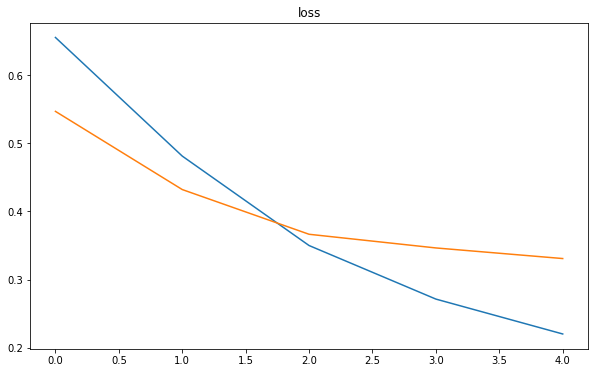

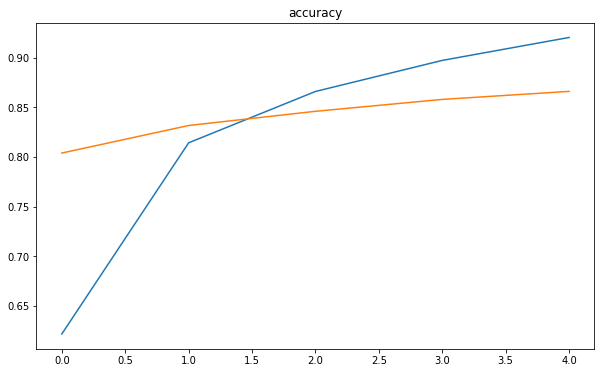

In [18]:
model_bidirectional_bs = keras.models.Sequential()
model_bidirectional_bs.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model_bidirectional_bs.add(keras.layers.Bidirectional(keras.layers.LSTM(32)))
model_bidirectional_bs.add(keras.layers.Dense(1, activation="sigmoid"))

model_bidirectional_bs.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

model_bidirectional_bs.summary()

history_bidirectional_bs = model_bidirectional_bs.fit(X_train_trim, y_train,
                    epochs=5, batch_size=256, validation_data=(X_valid_trim, y_valid))

plot_loss(history_bidirectional_bs)

plot_accuracy(history_bidirectional_bs)

scores_bidirectional_bs = model_bidirectional_bs.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model_bidirectional_bs.metrics_names[1], scores_bidirectional_bs[1]*100))

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 10)          100000    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 64)                11008     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 111,073
Trainable params: 111,073
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
196/196 [==============================] - 12s 50ms/step - loss: 0.6385 - accuracy: 0.6017 - val_loss: 0.3441 - val_accuracy: 0.8540
Epoch 2/10
196/196 [==============================] - 9s 46ms/step - loss: 0.2791 - accuracy: 0.8931 - val_loss: 0.3218 - val_accuracy: 0.8658
Epoch 3/10
196/196 [==============================] - 9s 46ms/step - loss: 0.2093 - accurac

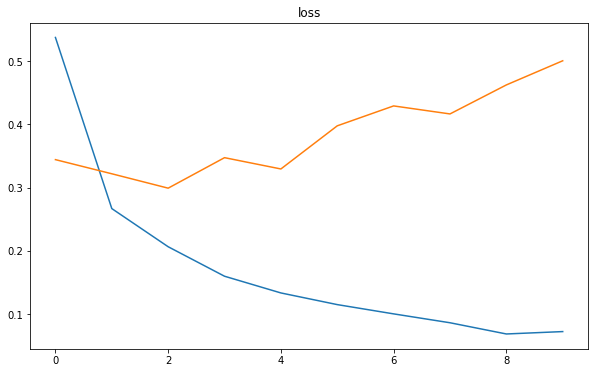

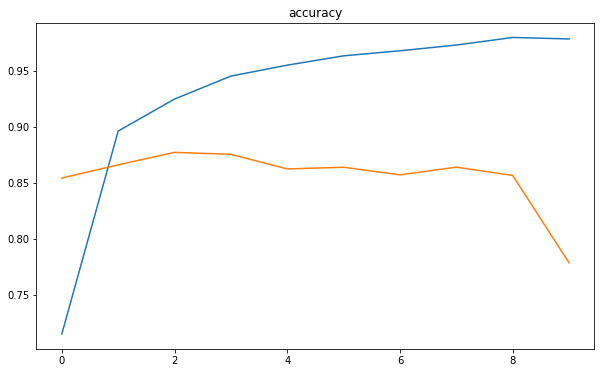

In [19]:
model_bidirectional_ep = keras.models.Sequential()
model_bidirectional_ep.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model_bidirectional_ep.add(keras.layers.Bidirectional(keras.layers.LSTM(32)))
model_bidirectional_ep.add(keras.layers.Dense(1, activation="sigmoid"))

model_bidirectional_ep.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

model_bidirectional_ep.summary()

history_bidirectional_ep = model_bidirectional_ep.fit(X_train_trim, y_train,
                    epochs=10, batch_size=128, validation_data=(X_valid_trim, y_valid))

plot_loss(history_bidirectional_ep)

plot_accuracy(history_bidirectional_ep)

scores_bidirectional_ep = model_bidirectional_ep.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model_bidirectional_ep.metrics_names[1], scores_bidirectional_ep[1]*100))

In this case, I tried to put a Dropout layer just after the Embedding layer and another one right before the last Dense layer and tested different Dropout values to see the results. The value of the Dropout probability that achieved the biggest reduction in terms of overfitting was 0.4 (for both layers). 
<br> In this way, I obtained the following results:

* loss: 0.2889
* accuracy: 0.8832

The plot of the loss on train and validation and the accuracy on train and validation can be seen above.


In order to reduce the overfitting on the original Bidirectional LSTM model (without Dropout), I modified it by increasing the batch size from 128 to 256. In this way, the gradient computation is more accurate since more examples are used to compute it, and we can reduce overfitting by a little bit. I obtained the following results (even if the model still quite overfits):

* loss: 0.3177
* accuracy: 0.8723

The plot of the loss on train and validation and the accuracy on train and validation can be seen above. <br> I also tested another model obtained by simply increasing the number of epochs from 5 to 10. However, I already knew that this was not a good idea, since increasing the training time for a model that is already overfitting just makes it overfit even more. In fact, this model obtained the following results:

* loss: 0.4911
* accuracy: 0.7789


and the plots clearly show how the model overfits even more the training set now.
